# Esercitazione 7
### Laboratorio di Simulazione Numerica

Il materiale dell'esercitazione sette di LSN è interamente raccolto nella cartella `Lab_07/Code`. Essa contiene quattro sotto-cartelle, dai nomi `7.1, 7.2, 7.3, 7.4`, corrispondenti alle quattro consegne dell'esercizio.

Ognuna di queste cartelle contiene una copia del programma `Monte_Carlo_NVT.cpp/h` e i risultati relativi all'esecuzione dello specifico compito.

---

In questa esercitazione, per eseguire in modo più comodo alcuni programmi, ho scritto uno script Python, che si trova nella descrizione dell'esercizio 7.1, con il quale ho reso automatici alcuni comandi da terminale. Per questa ragione, sconsiglio fortemente l'esecuzione del notebook: il processo potrebbe richiedere molto tempo.

---

La struttura del Jupyter Notebook è la seguente:
- 7.0 caricamento dei pacchetti e introduzione;
- 7.1 equilibrazione della simulazione, analisi delle funzioni di autocorrelazione e stima del numero efficace di blocchi;
- 7.2 funzione di distribuzione radiale $g(r)$;
- 7.3 aggiunta di $g(r)$ nel codice `MolDyn_NVE.cpp/h`
- 7.4 simulazione delle fasi solida, liquida e gassosa dell'Argon: stima di $g(r)$ e confronto dei risultati ottenuti con `Monte_Carlo_NVT.cpp/h` e `MolDyn_NVE.cpp/h`.

## 7.0 - Caricamento pacchetti e introduzione

In questa esercitazione affrontiamo un problema simile a quello proposto nell'esercitazione 4, utilizzando un approccio diverso e mettendo a confronto i risultati ottenuti con i due metodi. In questo caso, le mosse (`Move()`) a cui il sistema termodinamico è sottoposto sono tipiche delle Catene di Markov. Implementeremo infatti una catena di Markov tramite l'algoritmo di Metropolis, con l'intento di campionare la distribuzione densità di probabilità del sistema termodinamico, che assumiamo in _ensamble canonico_. Il nucleo di trasferimento stocastico che adottiamo propone i nuovi passi a partire da una distribuzione uniforme e di larghezza $\delta$. Anche in questa sede sarà necessario effettuare una calibrazione del passo, in modo da regolare il campionamento così che presenti un tasso di accettazione il più possibile vicino al 50%.

Questa volta, oltre a cambiare approccio, ci preoccupiamo più a fondo del fenomeno dell'autoccorrelazione che è intrinsecamente presente in simulazioni in cui i dati sono ottenuti in maniera sequenziale. Nel farlo, cerchiamo di capire quale sia la dimensione più efficace dei blocchi di dati su cui effettuare le misure che contribuiscono alla stima delle grandezze tramite metodo di blocking.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import tqdm as tqdm
from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

sns.set_theme(font_scale=1.7, style='whitegrid')

## 7.1 - Equilibrazione, funzione di autocorrelazione, analisi dei blocchi

In questa prima parte dell'esercizio ho aggiunto al codice `MonteCarlo_NVT.cpp/h` il metodo `Equilibrate_system(int Nequi)`, che implementa `Nequi` mosse di metropolis che non vengono coinvolte nella stima delle grandezze (il blocking parte al termine della fase di equilibrazione). Con lo script seguente vengono eseguiti tre lanci del programma, ciascuno dei quali corrispondente ad una specifica delle tre fasi termodinamiche in analisi. Per ciascuna delle tre run ho predisposto `Nequi=10'000` passi di equilibrazione e `Nstep=50'000` passi per blocco con un totale di `Nblks=10`. In totale stiamo utilizzando $5\times 10^5$ realizzazioni. 

---

Con l'intenzione di trovare un passo di Metropolis tale che l'accettazione in ogni blocco sia quanto più possibile vicina al 50% ho svolto alcuni tentativi. Per gli stati solido e liquido sono riuscito a trovare un valore tale da soddisfare la richiesta. Per quanto riguarda lo stato gassoso, anche impostando come passo circa la metà del lato del box analizzato non sono riuscito ad ottenere accettazioni migliori del 62%. Le scelte definitive, con le quali ho eseguito il programma nelle celle seguenti sono:
- fase solida $\delta_s = 0.11$
- fase liquida $\delta_l = 0.2$
- fase gassosa $\delta_g = 5.0$

In [3]:
path = "Code/7.1/"
istant = []

ist_files = ["output_solid.dat", "output_liquid.dat", "output_gas.dat"]
inp_files = ["input.solid", "input.liquid", "input.gas"]
phase = ['Solido', 'Liquido', "Gas"]
colors = ['orange', 'red', 'purple']

In [47]:
print('-----------------------------------------------------')
print("Stiamo eseguendo 500'000 passi di MCMC")
print("Questo avverrà per tre volte")
print("Il processo potrebbe richiedere molto tempo.")
print("-----------------------------------------------------")

for i in range(3):
    print("Esecuzione del programma per lo stato " + phase[i])
    subprocess.call("cp " + str(inp_files[i]) + " input.dat", cwd = path, shell=True)
    subprocess.call("rm " + str(ist_files[i]), cwd = path, shell=True)
    subprocess.call("make clean", cwd = path, shell=True)
    subprocess.call("make", cwd = path, shell=True)
    subprocess.call("./Monte_Carlo_NVT.exe", cwd = path, shell=True)
    subprocess.call("cp istant_output.dat " + str(ist_files[i]), cwd = path, shell=True)
    
print("Fine dell'esecuzione!")

-----------------------------------------------------
Stiamo eseguendo 500'000 passi di MCMC
Questo avverrà per tre volte
Il processo potrebbe richiedere molto tempo.
-----------------------------------------------------
Esecuzione del programma per lo stato Solido
Esecuzione del programma per lo stato Liquido
Esecuzione del programma per lo stato Gas
Fine dell'esecuzione!


In [7]:
for i in range(3):
    istant.append(np.loadtxt(path+ist_files[i]))

In [8]:
len_ist = len(istant)

def plot_equilibration(mylist, steps, idx, title, col1, col2):
    plt.figure(figsize=(20,5))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.plot(mylist[idx].T[0][:steps], color=col1, linewidth=3, alpha=0.5, label='Energia')
    plt.xlabel('# passi')
    plt.ylabel('U/N [LJ units]')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(mylist[idx].T[2][:steps], color=col2, linewidth=3, alpha=0.5, label='Pressione')
    plt.xlabel('# passi')
    plt.ylabel('P [LJ units]')
    plt.legend()
    plt.tight_layout()
    
def plot_final(mylist, steps, idx, title, col1, col2):
    plt.figure(figsize=(20,5))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.plot(mylist[idx].T[0][-steps:], color=col1, linewidth=3, alpha=0.5, label='Energia')
    plt.xlabel('# passi')
    plt.ylabel('U/N [LJ units]')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(mylist[idx].T[2][-steps:], color=col2, linewidth=3, alpha=0.5, label='Pressione')
    plt.xlabel('# passi')
    plt.ylabel('P [LJ units]')
    plt.legend()
    plt.tight_layout()

### L'equilibrazione del sistema

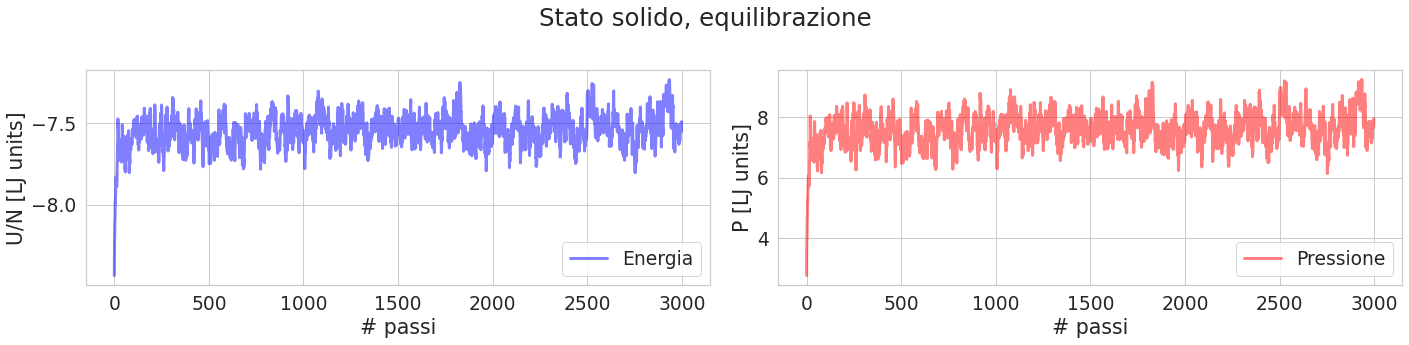

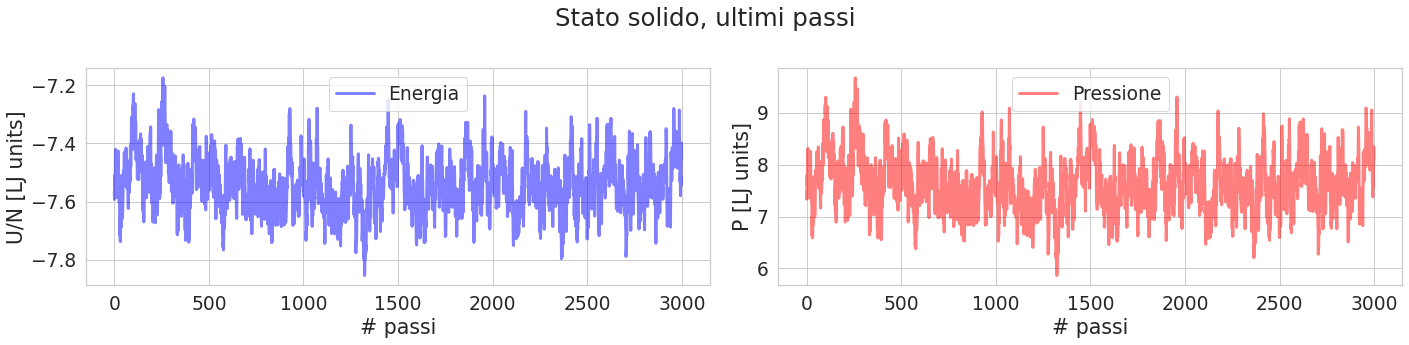

In [9]:
plot_equilibration(istant, 3000, 0, 'Stato solido, equilibrazione', 'blue', 'red')
plot_final(istant, 3000, 0, 'Stato solido, ultimi passi', 'blue', 'red')

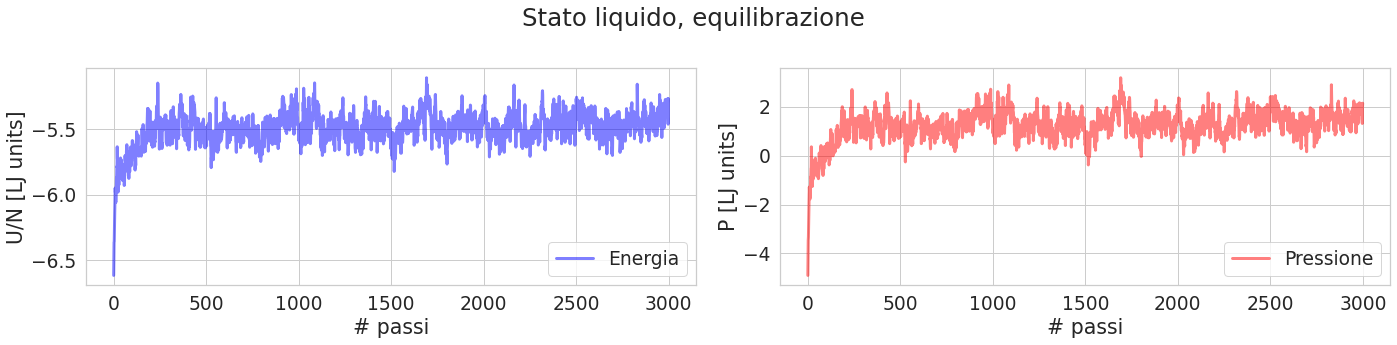

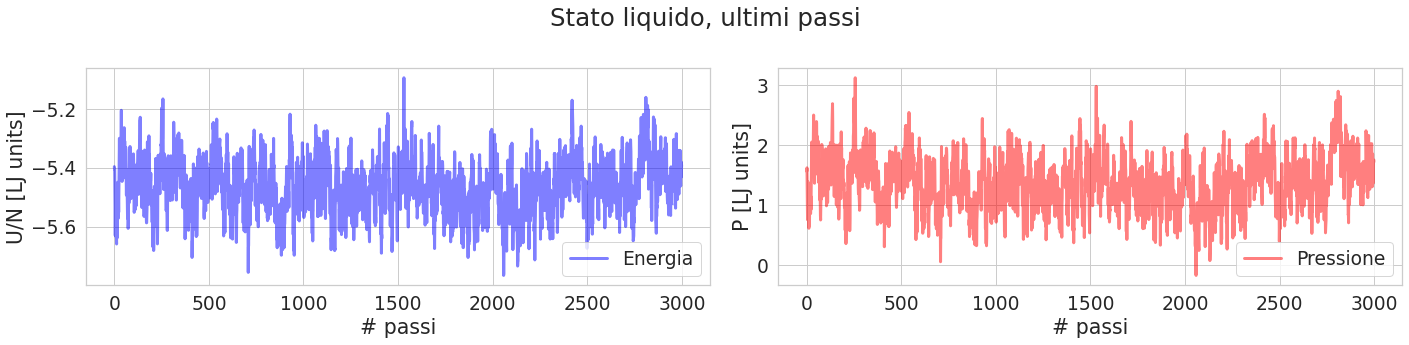

In [10]:
plot_equilibration(istant, 3000, 1, 'Stato liquido, equilibrazione', 'blue', 'red')
plot_final(istant, 3000, 1, 'Stato liquido, ultimi passi', 'blue', 'red')

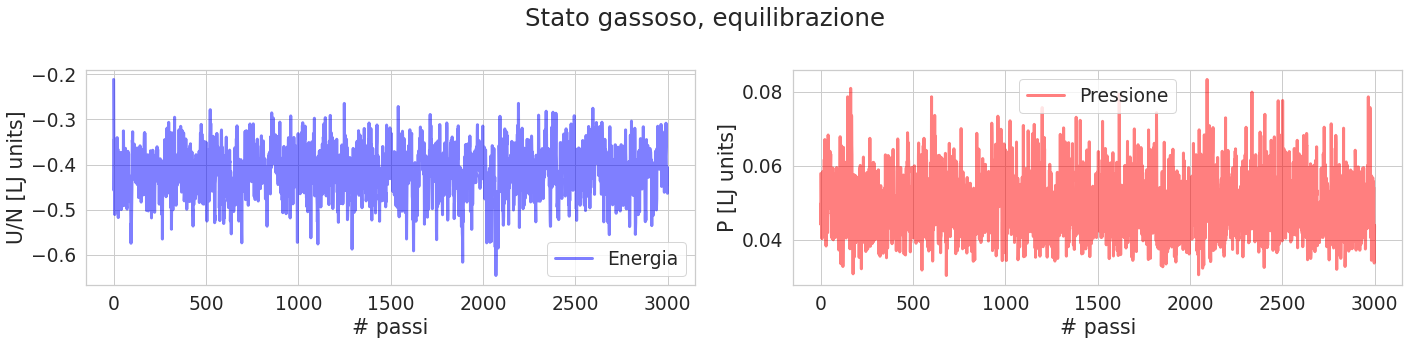

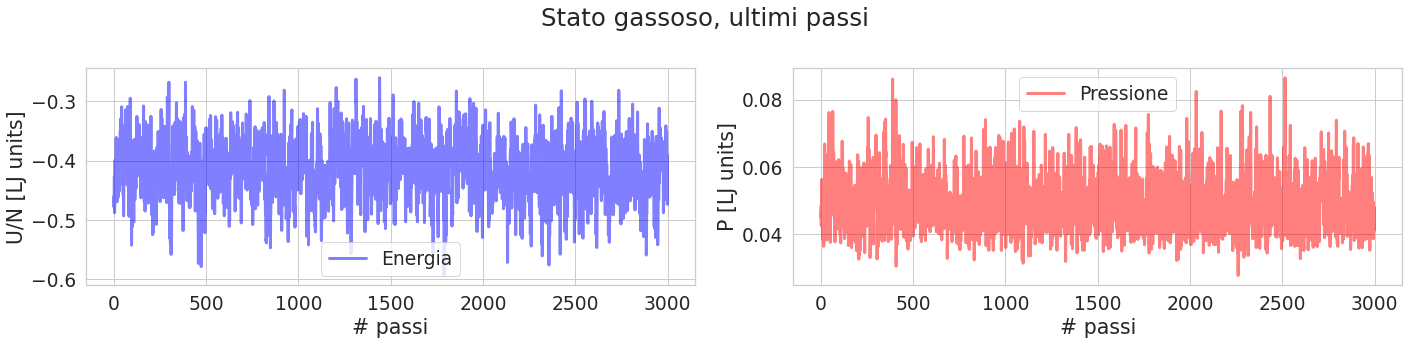

In [11]:
plot_equilibration(istant, 3000, 2, 'Stato gassoso, equilibrazione', 'blue', 'red')
plot_final(istant, 3000, 2, 'Stato gassoso, ultimi passi', 'blue', 'red')

__Figura 1:__ in figura ho rappresentato i primi e gli ultimi tremila passi delle simulazioni introdotte in precedenza. Nel caso di solido e liquido notiamo che sono necessarie poche decine di passi (meno di cinquecento) perché i valori di $U/N$ e $P$ inizino ad oscillare attorno ad un valore specifico. Nel caso del gas, invece, questo avviene sin dal primo momento. In altre parole, l'algoritmo di Metropolis necessita, in questo caso, di un breve processo di equilibrazione.

### La taglia dei blocchi

Vogliamo adesso comprendere quale sia il giusto numero di blocchi da scegliere per far sì che i dati contenuti in blocchi diversi siano tra loro quanto più scorrelati possibile. Dunque calcoliamo, a partire dai dati istantanei ottenuti, il valore delle funzioni di autocorrelazione dei dati di energia potenziale media per particella e pressione  nelle tre fasi termodinamiche di interesse. Nella cella seguente implemento la funzione di autocorrelazione come segue: 

$$ AC(\tau) = \frac{ \frac{1}{t-\tau}\sum_{t'=0}^{t-\tau}x(t')x(t'+\tau) -\frac{1}{t-\tau}\sum_{t'=0}^{t-\tau} x(t') \times \sum_{t'=0}^{t-\tau} x(t'+\tau) }{\frac{1}{\tau} \sum_{t'=0}^t x^2(t') - \biggl( \frac{1}{\tau} \sum_{t'=0}^t x(t')\biggr)^2 } $$

In pratica, il valore puntuale (a $\tau$ fissato) della funzione di autocorrelazione è dato da tutti i contributi all'autocorrelazione dovuti ai valori di pressione o energia che distano tra loro $\tau$ nelle mie liste. Prima di procedere con il calcolo elimino dalle liste le misure ottenute nel periodo di equilibrazione del sistema, che corrisponde a diecimila passi di metropolis.

---

Ho deciso di analizzare l'autocorrelazione delle misure per $\tau \in [0,500]$.

In [12]:
# voglio eliminare i punti corrispondenti all'equilibrazione

energies  = []
pressures = []

for i in range(3):
    energies.append(istant[i].T[0][10000:])     #tre liste, energie   di solido, liquido, gas
    pressures.append(istant[i].T[2][10000:])    #tre liste, pressioni di solido, liquido, gas

In [14]:
N = len(energies[1])    # 500'000

La cella seguente viene eseguita in un tempo $t\sim 16$ min, come è possibile leggere a fianco delle barre di caricamento stampate tramite il metodo `tqdm.tqdm` dell'omonima libreria.

In [47]:
AC_U = []
AC_P = []


npoints = 500

for i in range(3):
    print("Funzione di autocorrelazione, fase " + phase[i])
    ac_u = []
    ac_p = []
    # ciclo su tutte le taglie tau
    for tau in tqdm.tqdm(range(npoints)):
        U_minus_tau = energies[i][:N - tau]       # taglio gli ultimi tau valori
        P_minus_tau = pressures[i][:N - tau]
        U_plus_tau = energies[i][tau:]            # taglio i primi tau valori
        P_plus_tau = pressures[i][tau:]
        
        # in questo modo, moltiplicando U_minus_tau[i]*U_plus_tau[i] sto eseguendo il prodotto di due elementi
        # che si trovano distanziati esattamente di tau (con tau che varia nel corso dei 500 loop del ciclo for)

        n = len(U_minus_tau)                      # corrisponde al nostro t-tau = 500'000 - tau
        
        ac_u.append((sum(U_minus_tau * U_plus_tau)/n - sum(U_minus_tau) / n * sum(U_plus_tau) / n)   #numeratore
                    / np.std(energies[i])**2)                                                        #varianza
        ac_p.append((sum(P_minus_tau * P_plus_tau)/n - sum(P_minus_tau) / n * sum(P_plus_tau) / n)
                    / np.std(pressures[i])**2)
        
    # ancora una volta tre liste, una per fase 
    AC_U.append(ac_u)
    AC_P.append(ac_p)


  0%|                                                                       | 0/500 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Solido


  0%|                                                                       | 0/500 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Liquido


  0%|                                                                       | 0/500 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Gas


100%|█████████████████████████████████████████████████████████████| 500/500 [05:27<00:00,  1.53it/s]


In [85]:
def plot_ac(idx, cut1, cut2, col1, col2, title):
    plt.figure(figsize=(18,6))
    plt.suptitle(title)
    
    plt.subplot(1,2,1)
    plt.plot(AC_U[idx], linewidth=3, color=col1, alpha=0.6, label='U/N')
    plt.plot(AC_P[idx], linewidth=3, color=col2, alpha=0.6, label='P')
    plt.axvspan(0, cut1, facecolor='black', alpha=0.15, label=r'Regione dei $\tau$ da escludere')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$AC(\tau)$')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(AC_U[idx][cut1:], linewidth=3, color=col1, alpha=0.6, label='U/N')
    plt.plot(AC_P[idx][cut2:], linewidth=3, color=col2, alpha=0.6, label='P')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$AC(\tau)$')
    plt.legend()
    plt.tight_layout()

    plt.show()

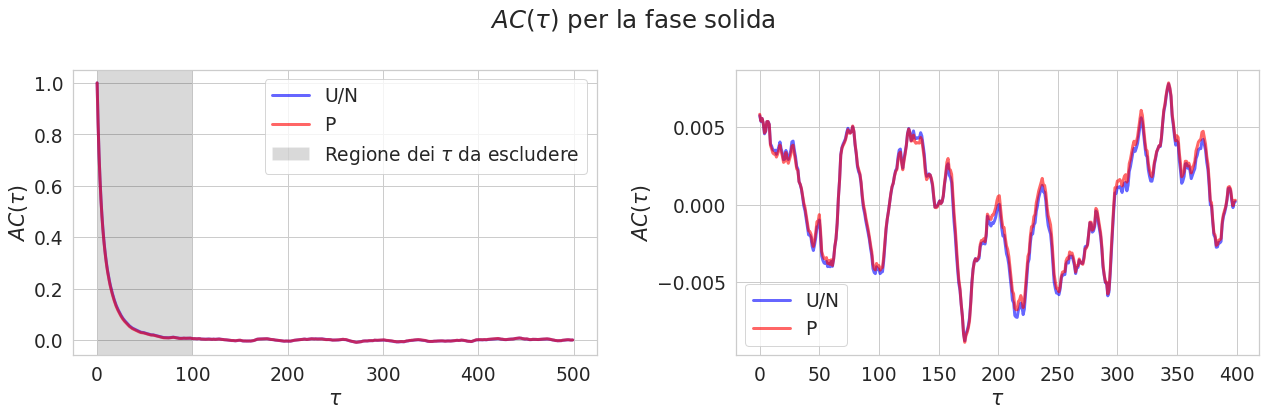

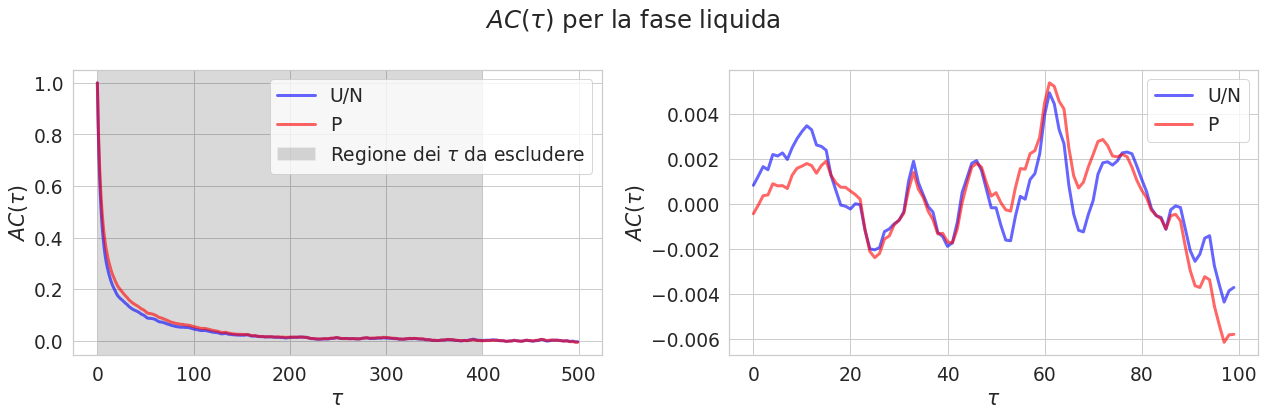

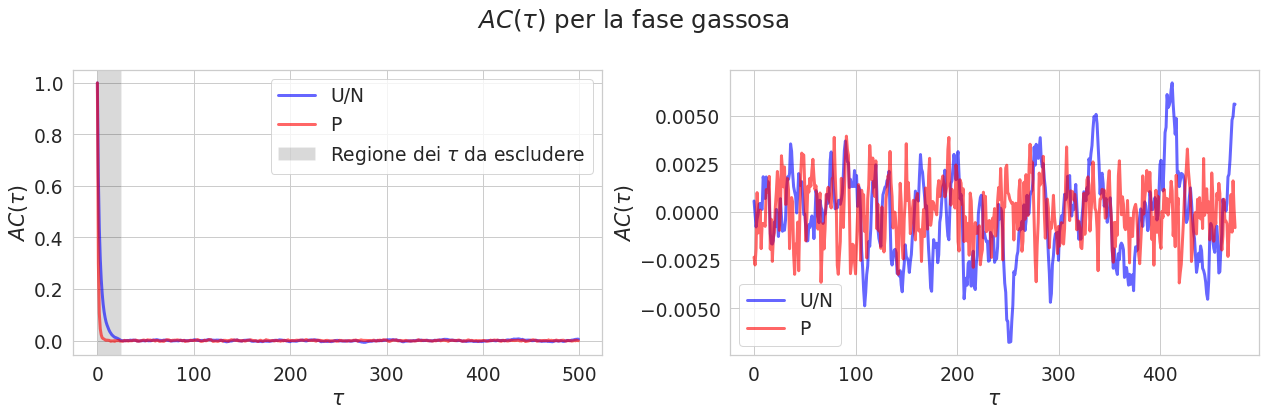

In [95]:
plot_ac(0, 100, 100, 'blue', 'red', r'$AC(\tau)$ per la fase solida')
plot_ac(1, 400, 400, 'blue', 'red', r'$AC(\tau)$ per la fase liquida')
plot_ac(2, 25, 25, 'blue', 'red', r'$AC(\tau)$ per la fase gassosa')

__Figura 2:__ dall'alto verso il basso, andamento del valore dell'autocorrelazione delle misure di $U/N$ e di $P$ in funzione di $\tau$ per gli stati solido, liquido e gassoso. Nelle immagini a sinistra, andamendo di $AC(\tau)$ su tutto il dominio dei $\tau$ analizzato. A destra, andamento della stessa funzione avendo escluso la porzione di intervallo in cui $AC(\tau)$ è apprezzabilmente maggiore di zero. Lo stato che sembra "liberarsi" più rapidamente dell'autocorrelazione tra i dati è il gas. Nel caso del gas, infatti, la curva rappresentativa del valore dell'autocorrelazione raggiunge un valore prossimo allo zero per $\tau>25$. Questo è un risultato che rispecchia la dinamica molto più disordinata e frenetica di un sistema allo stato gassoso. Analizzando il comportamento di $AC(\tau)$ per la fase solida, possiamo assumere raggiunta una condizione di scorrelazione tra i dati per tagli di dimensione $\tau>100$. Oltre tale valore, infatti, la funzione inizia ad oscillare in modo contenuto attorno allo zero. Lo stato che conserva per più tempo la memoria statistica del sistema è quello liquido, infatti, in entrambi i casi di $U/N$ e $P$ vediamo che la $AC(\tau)$ rimane apprezzabilmente sopra lo zero fino a taglie $\tau > 400$. Queste considerazioni servono a stabilire che i blocchi di dati con cui effettuiamo le misure (per esempio tramite il metodo _blocking_) devono avere dimensioni ben superiori ai numeri che ho citato. Infatti, sebbene possiamo considerare scorrelati due dati che si trovano ad una distanza maggiore di $\tau_m$ in una sequenza, per poter affermare che una misura sul blocco è ricavata tramite dati scorrelati da quelli utilizzati in un altro blocco è necessario confinare questi effetti di correlazione ai bordi dei blocchi. Se, per esempio, consideriamo il caso del liquido, avendo stabilito che $400$ è il passo minimo per ritenere scorrelati due elementi, allora abbiamo necessità di ricavare dei blocchi di dimensione ben superiore a $400$, così che eventuale memoria statistica rimanga vincolata ai soli bordi del blocco di dati utilizzato.

Sempre nell'ottica di andare a stabilire la taglia ottimale dei blocchi, procediamo in direzione opposta: una volta capito che un blocco non deve contenere __meno__ di $\tau_m$ dati, andiamo a controllare fino a che valore $\tau_M>\tau_m$ è conveniente spingersi in termini di precisione statistica. In altre parole, oltre che valore $\tau_M$ è inutile allargare il blocco perché ci troveremmo a spendere tempo computazionale senza ottenere un guadagno in termini di precisione? 

Per rispondere a questa domanda eseguiamo numerose misure utilizzando il metodo _blocking_ e considerando valori di taglia dei blocchi $L\in[10,5000]$. Rappresentiamo infine in un grafico il valore dell'incertezza registrata sull'ultima misura.

In [11]:
# implementiamo il metodo blocking

def error(AV,AV2,n):  
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def blocking(r,L):   
    
    M = len(r)
    N=int(M/L)
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       
        av2[i] = (ave[i])**2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] 
            su2_prog[i] += av2[j] 
        sum_prog[i]/=(i+1) 
        su2_prog[i]/=(i+1) 
        err_prog[i] = error(sum_prog,su2_prog,i) 
        
    return err_prog[len(err_prog)-1]  

In [42]:
L = np.arange(10, 5000, 20)       # da L=10 a L=5000 a passi di 20

La cella seguente impiega molto tempo di calcolo, sconsiglio di eseguirla.

In [39]:
ERR_U = []
ERR_P = []

In [252]:
%%time

for iphase in range(3): 

    print("Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato " + phase[iphase])
    err_u = []
    err_p = []
    for i in tqdm.tqdm(range(len(L))):
        err_u.append(blocking(energies[iphase] , L[i]))
        err_p.append(blocking(pressures[iphase], L[i]))
    
    ERR_U.append(err_u)
    ERR_P.append(err_p)

  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Solido


  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Liquido


  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Gas


100%|█████████████████████████████████████████████████████████████| 250/250 [57:03<00:00, 13.70s/it]

CPU times: user 2h 50min 59s, sys: 1.14 s, total: 2h 51min 1s
Wall time: 2h 51min 3s


In [40]:
ERR_U.append(np.loadtxt("Results/err_U_sol.dat"))
ERR_U.append(np.loadtxt("Results/err_U_liq.dat"))
ERR_U.append(np.loadtxt("Results/err_U_gas.dat"))
ERR_P.append(np.loadtxt("Results/err_P_sol.dat"))
ERR_P.append(np.loadtxt("Results/err_P_liq.dat"))
ERR_P.append(np.loadtxt("Results/err_P_gas.dat"))

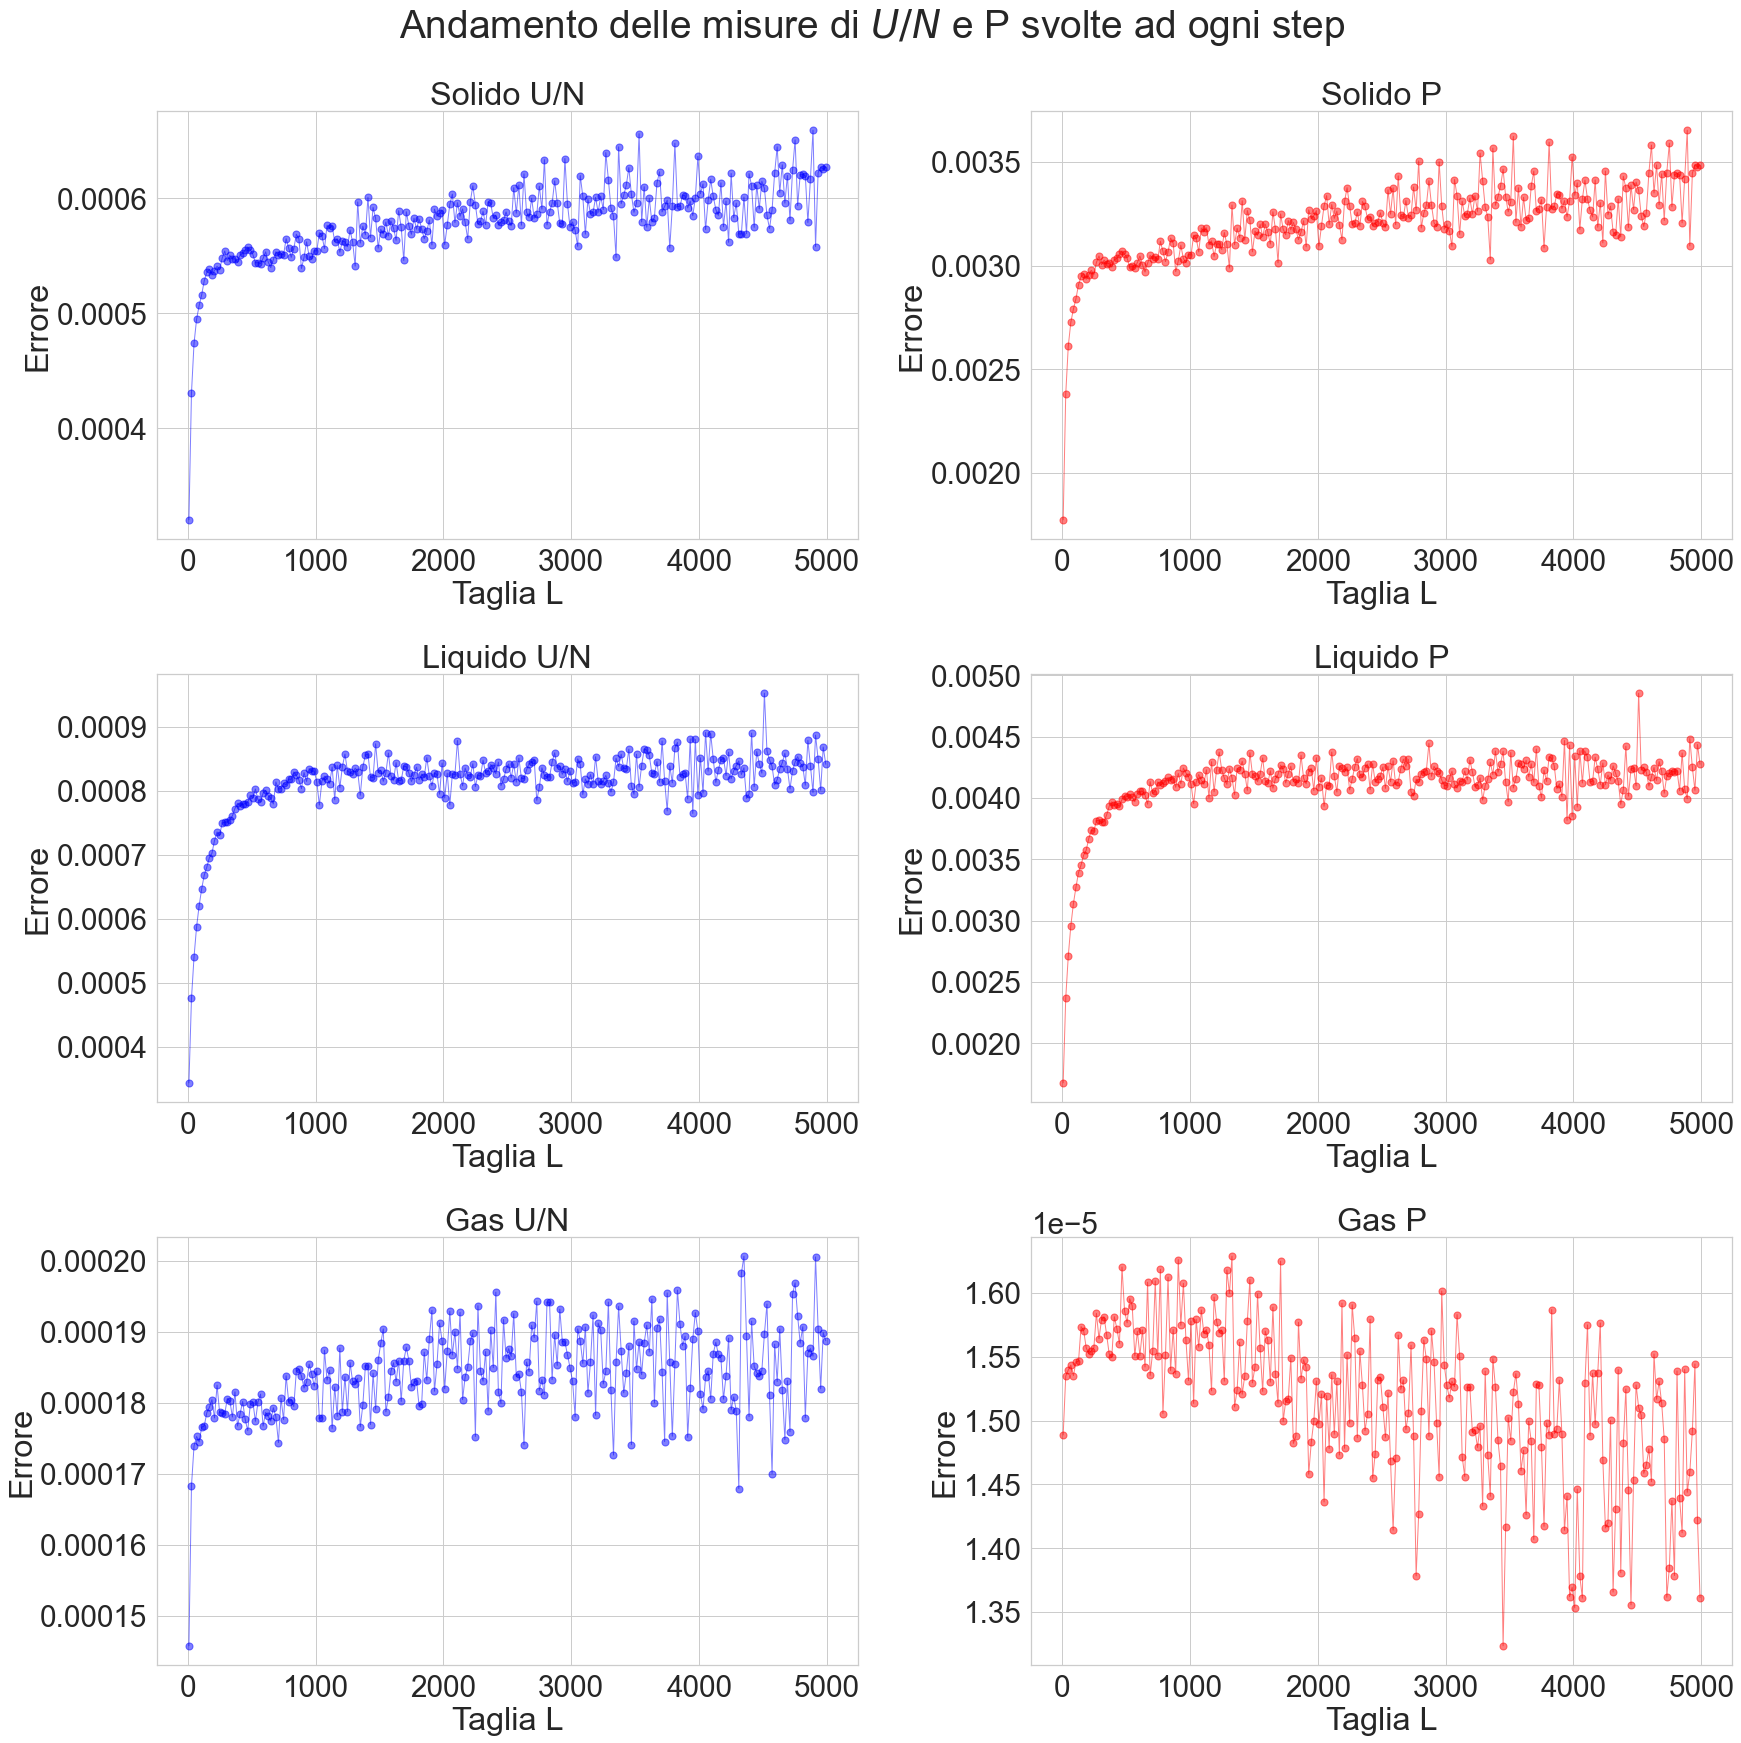

In [44]:
plt.figure(figsize=(25,25))
sns.set_theme(font_scale=2.7, style='whitegrid')

plt.suptitle('Andamento delle misure di $U/N$ e P svolte ad ogni step')

for i in range(0,6,2):
    
    plt.subplot(3,2,i+1)
    plt.title(phase[int(i/2)]+" U/N")
    plt.scatter(L, ERR_U[int(i/2)], s=50, alpha=0.5, color='blue')
    plt.plot(L, ERR_U[int(i/2)], linewidth=1, alpha=0.5, color='blue')
    plt.xlabel('Taglia L')
    plt.ylabel('Errore')
    
    plt.subplot(3,2,i+2)
    plt.title(phase[int(i/2)]+" P")
    plt.scatter(L, ERR_P[int(i/2)], s=50, alpha=0.5, color='red')
    plt.plot(L, ERR_P[int(i/2)], linewidth=1, alpha=0.5, color='red')
    plt.xlabel('Taglia L')
    plt.ylabel('Errore')

plt.tight_layout()    
plt.show()

__Figura 3:__ in questa figura ho stampato l'errore finale ottenuto stimando pressione (in rosso) ed energia interna media per sito (in blu) tramite il metodo delle medie a blocchi in funzione della taglia dei blocchi. L'idea è quella di capire oltre che taglia non ha senso spingersi in termini di guadagno statistico. Notiamo che nel caso dello stato solido viene raggiunta una condizione ottimale intorno a $\tau\simeq 2000$. Nel caso del liquido i punti che rappresentano il valore degli errori iniziano ad oscillare attorno ad un valore costante per $\tau>1000$. Infine, considerando i grafici relativi al gas, registriamo un guadagno in termini di precisione statistica fino a valori di $\tau\simeq 2000$. 


La decisione finale sulla taglia dei blocchi è dovuta alla combinazione dei due studi effettuati.

Per essere certo di confinare i fenomeni di autocorrelazione sul bordo e volendo al contempo costruire dei blocchi di taglia utile ho deciso di eseguire le simulazioni seguenti adottando $L_{solid} = L_{gas} = 3000$ e $L_{liquid}= 5000$.



## 7.2 - 7.3 - 7.4 - Stima della $g(r)$ nelle tre fasi e utilizzando due approcci diversi

Introduciamo ora $g(r)$, funzione di _distribuzione delle coppie radiale_, che esprime la probabilità di trovare due particelle ad una precisa distanza reciproca $r$. Si tratta dunque di una funzione di conteggio che deve essere opportunamente normalizzata tenendo conto del tipo di sistema che si sta analizzando. Nel nostro caso, effettuiamo un vero e proprio conteggio: 
1. definiamo il _range_ di raggi di interesse $r\in[0,\text{L}_{box}/2]$ (tramite i valori iniziali di densità e numero di particelle si calcola il volume e, di conseguenza, una stima del lato del box in cui stiamo eseguendo la simulazione);
2. dividiamo questo intervallo in $N_{bin}$ segmenti;
3. ad ogni passo della simulazione contiamo quante particelle si trovano ad una distanza $r\in \text{bin}[x_i, x_{i+1}]$ e, per ogni coppia trovata, aggiungiamo due unità al parziale relativo a quel bin;
4. terminato il processo per tutte le particelle normalizziamo i valori ottenuti in ciascun bin utilizzando la quantità: $$ \rho N \Delta V(r),\qquad \text{dove} \qquad \Delta V(r) = \frac{4\pi}{3} \bigl[(r+dr)^3-r^3 \bigr].$$

In questo modo otteniamo $N_{bin}$ misure, ciascuna corrispondente al valore che $g(r)$ assume per il sistema in esame alla distanza $r$, che è approssimata dai segmenti corrispondenti ai bin. Come in tutti i casi in cui ci proponiamo di stimare una grandezza, anche in questo utilizziamo il metodo delle medie a blocchi per stimare i valori di $g(r)$.

---

Questo approccio è utilizzabile all'interno del codice costruito per questa esercitazione ma anche nel caso dell'algoritmo di dinamica molecolare implementato per lo svolgimento dell'esercitazione quattro. Nel codice `MolDyn_NVE.cpp/h` avevo scritto un metodo `blocking` che opera in modo indipendente sulle singole componenti di un vettore `measure`. Per adattare il problema alla misura della $g(r)$ ho dunque aumentato la dimensione delle variabili da misurare da quattro a $4+N_{bin}$. In questo modo, ho eseguito altrettante operazioni indipendenti di media a blocchi, sfruttando la struttura dinamica del metodo.

---


Per quanto riguarda la simulazione tramite codice NVT ho deciso di svolgere in tutti e tre i casi $2000$ passi di equilibrazione ed eseguire successivamente le misure tramite _blocking_ utilizzando quaranta blocchi e le taglie stabilite in precedenza. Nel caso del codice NVE ho invece variato maggiormente i parametri, in funzione delle scale di oscillazione dei singoli problemi (nel caso del gas, per esempio, è necessario eseguire simulazioni molto più lunghe). Ho raccolto nelle tabelle seguenti i valori finali scelti per lanciare le varie simulazioni.

#### Simulazioni stato solido
|Parametro|NVE|NVT|
|---|---|---|
|`L`| `3'000` | `3'000` |
| `Nblks` | `50` | `40`|
| `Nequi`| `3'000` | `2'000`|

---

#### Simulazioni stato liquido
|Parametro|NVE|NVT|
|---|---|---|
|`L`| `5'000` | `50'00` |
| `Nblks` | `50` | `40`|
| `Nequi`| `3'000` | `2'000`|

---

#### Simulazioni stato gassoso

In questo caso ho eseguito più volte la simulazione, cercando di variare le combinazioni dei parametri. Ho nominato ogni simulazione come NVE_$nn$k, dove $nn$ richiama il numero di passi di equilibrazione utilizzato. 

|Parametro|NVE_05k | NVE_10k | NVE_50k |NVT|
|---|---|---|---|---|
|`L`| `3'000` | `1'000` |`3'000` | `3'000` |
| `Nblks` | `100` |`100`| `100`| `40`|
| `Nequi`| `5'000`| `10'000` |`50'000` | `2'000`|

### Esecuzione delle simulazioni NVT

In [13]:
from IPython.display import clear_output

path = "Code/7.2/"
gofr_NVT = []

NVT_files = ["gofr_NVT_solid.dat", "gofr_NVT_liquid.dat", "gofr_NVT_gas.dat"]
inp_files = ["input.solid", "input.liquid", "input.gas"]
phase = ['Solido', 'Liquido', "Gas"]
colors = ['orange', 'red', 'purple']

NVT_meas_U = []
NVT_err_U  = []
NVT_meas_P = []
NVT_err_P = []

NVTblks = 20

__NB:__ l'esecuzione della cella seguente richiede qualche minuto di tempo.

In [49]:
print('-----------------------------------------------------')
print("Stiamo eseguendo le misure per stimare g(r)")
print("Questo avverrà per tre volte: una per ogni fase.")
print("Il processo potrebbe richiedere del tempo.")
print("-----------------------------------------------------")

for i in range(3):
    print("Esecuzione del programma per lo stato " + phase[i])
    print("---------------------------------------------------------")
    subprocess.call("cp " + str(inp_files[i]) + " input.dat", cwd = path, shell=True)
    subprocess.call("make clean", cwd = path, shell=True)
    subprocess.call("make", cwd = path, shell=True)
    subprocess.call("./Monte_Carlo_NVT.exe", cwd = path, shell=True)
    subprocess.call("cp output.gave.0 " + str(NVT_files[i]), cwd = path, shell=True)
    
    NVT_meas_U.append(np.loadtxt("Code/7.2/output.epot.0").T[2])                  #salvo U/N
    NVT_err_U.append(np.loadtxt("Code/7.2/output.epot.0").T[3])                    #e l'errore
                                                                                   
    NVT_meas_P.append(np.loadtxt("Code/7.2/output.pres.0").T[2])        #salvo P
    NVT_err_P.append(np.loadtxt("Code/7.2/output.pres.0").T[3])         #e l'errore
                                                                                   

    clear_output()
    
print("Fine dell'esecuzione!")

Fine dell'esecuzione!


In [50]:
r_range  = []
gofr_NVT = []
err_NVT  = []

for i in range(3):
    r_range.append(np.loadtxt(path+NVT_files[i]).T[0])
    gofr_NVT.append(np.loadtxt(path+NVT_files[i]).T[1])
    err_NVT.append(np.loadtxt(path+NVT_files[i]).T[2])

### Caricamento dei risultati

In [51]:
gofr_solid  = np.loadtxt('Results/gofr_NVT_solid.0')
gofr_liquid = np.loadtxt('Results/gofr_NVT_liquid.0')
gofr_gas    = np.loadtxt('Results/gofr_NVT_gas.0')

In [52]:
NVE_solid = np.loadtxt("Results/gofr_NVE_solid.dat")
NVE_liquid = np.loadtxt("Results/gofr_NVE_liquid.dat")

NVE_gas_5000 = np.loadtxt("Results/gofr_NVE_gas_5000.dat")
NVE_gas_10000 = np.loadtxt("Results/gofr_NVE_gas_10000.dat")
NVE_gas_50000 = np.loadtxt("Results/gofr_NVE_gas_50000.dat")

In [53]:
hist_vals_sol = []
hist_errs_sol = []
hist_vals_liq = []
hist_errs_liq = []
hist_vals_gas_05k = []
hist_errs_gas_05k = []
hist_vals_gas_10k = []
hist_errs_gas_10k = []
hist_vals_gas_50k = []
hist_errs_gas_50k = []

nbins = 100
nprop = 4
binsize = ()

r_liq = gofr_liquid.T[0]
r_sol = gofr_solid.T[0]
r_gas = gofr_gas.T[0]

for i in range(8,int(2*(nbins+nprop)),2):                    # non ho scelto sempre la stessa
    hist_vals_sol.append(NVE_solid.T[i][49])                 # taglia di blocchi 
    hist_errs_sol.append(NVE_solid.T[i+1][49])               # i valori di L sono raccolti
    hist_vals_liq.append(NVE_liquid.T[i][49])                # nelle tabelle mostrate sopra
    hist_errs_liq.append(NVE_liquid.T[i+1][49])
    hist_vals_gas_05k.append(NVE_gas_5000.T[i][59])
    hist_errs_gas_05k.append(NVE_gas_5000.T[i+1][59])
    hist_vals_gas_10k.append(NVE_gas_10000.T[i][99])
    hist_errs_gas_10k.append(NVE_gas_10000.T[i+1][99])
    hist_vals_gas_50k.append(NVE_gas_50000.T[i][99])
    hist_errs_gas_50k.append(NVE_gas_50000.T[i+1][99])

### Visualizzazione delle $g(r)$

In [54]:
sns.set_theme(font_scale=2.2, style='whitegrid')

def plot_gofr(r, gofr_NVT, gofr_NVE, err_NVT, err_NVE, title, col1, col2, lab_NVT, lab_NVE,_x1, _x2, _y1, _y2):
    fig, ax = plt.subplots(figsize=[20, 8])
    plt.title(title)
    plt.xlabel('r [LJ units]')
    plt.ylabel('g(r)')
    
    axins=zoomed_inset_axes(ax,4,loc=2)   
    x1, x2, y1, y2 = _x1, _x2, _y1, _y2
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    
    ax.errorbar(r, gofr_NVE, yerr=err_NVE, color=col2, linewidth=3, alpha=0.5, label=lab_NVE, marker='.', markersize=1)
    ax.errorbar(r, gofr_NVT, yerr=err_NVT, color=col1, linewidth=3, alpha=0.5, label=lab_NVT, marker='.', markersize=1)
    ax.vlines(2**(1/6), 0, np.max(gofr_NVT)+0.5, color='green',linewidth=2, label=r'$r_m/\sigma = 2^{1/6}$')
    ax.hlines(1, 0, r[99], linestyle='--', color='black', linewidth=1)
    axins.errorbar(r, gofr_NVE, yerr=err_NVE, color=col2, linewidth=3, alpha=0.5, label=lab_NVE, marker='.', markersize=1)
    axins.errorbar(r, gofr_NVT, yerr=err_NVT, color=col1, linewidth=3, alpha=0.5, label=lab_NVT, marker='.', markersize=1)
    ax.legend()
    mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')



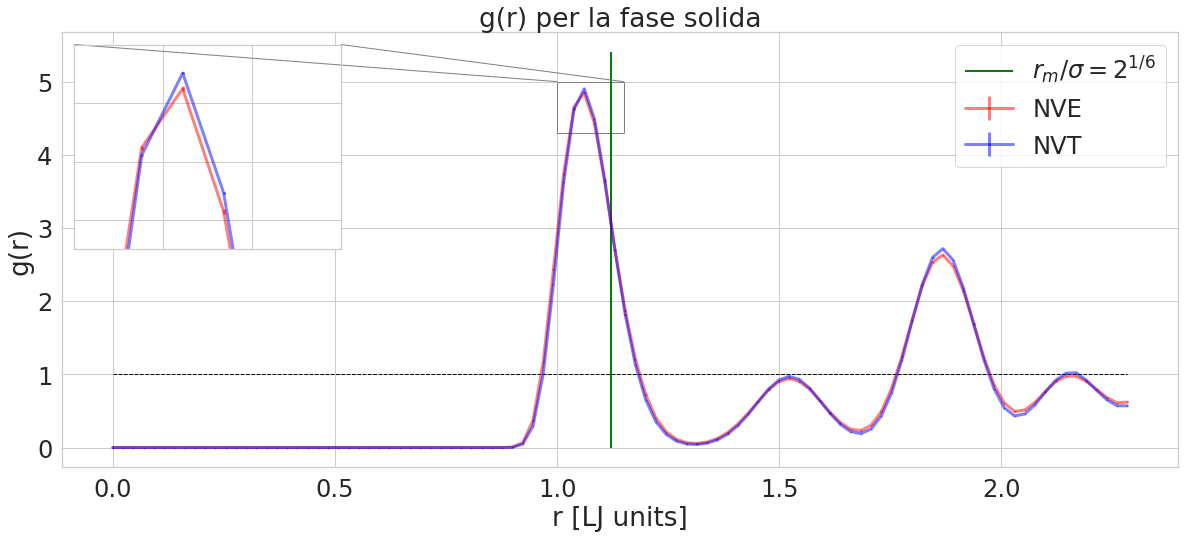

In [55]:
plot_gofr(r_range[0], gofr_NVT[0], hist_vals_sol, err_NVT[0], hist_errs_sol, 
         'g(r) per la fase solida', 'blue', 'red', 'NVT', 'NVE', 1, 1.15, 4.3, 5)

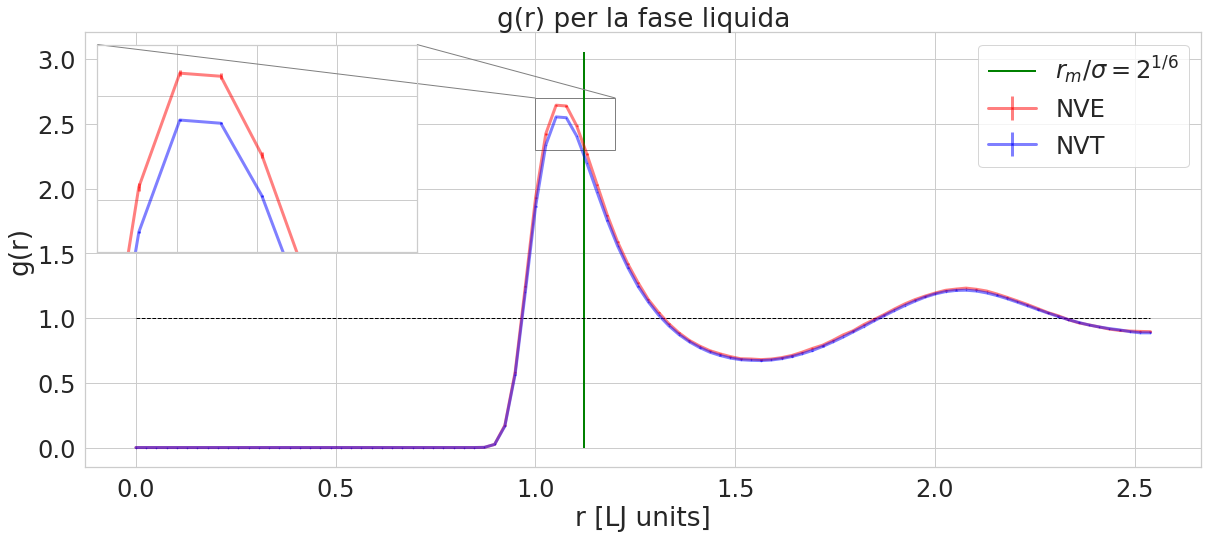

In [56]:
plot_gofr(r_range[1], gofr_NVT[1], hist_vals_liq, err_NVT[1], hist_errs_liq, 
         'g(r) per la fase liquida', 'blue', 'red', 'NVT', 'NVE', 1, 1.2, 2.3, 2.7)

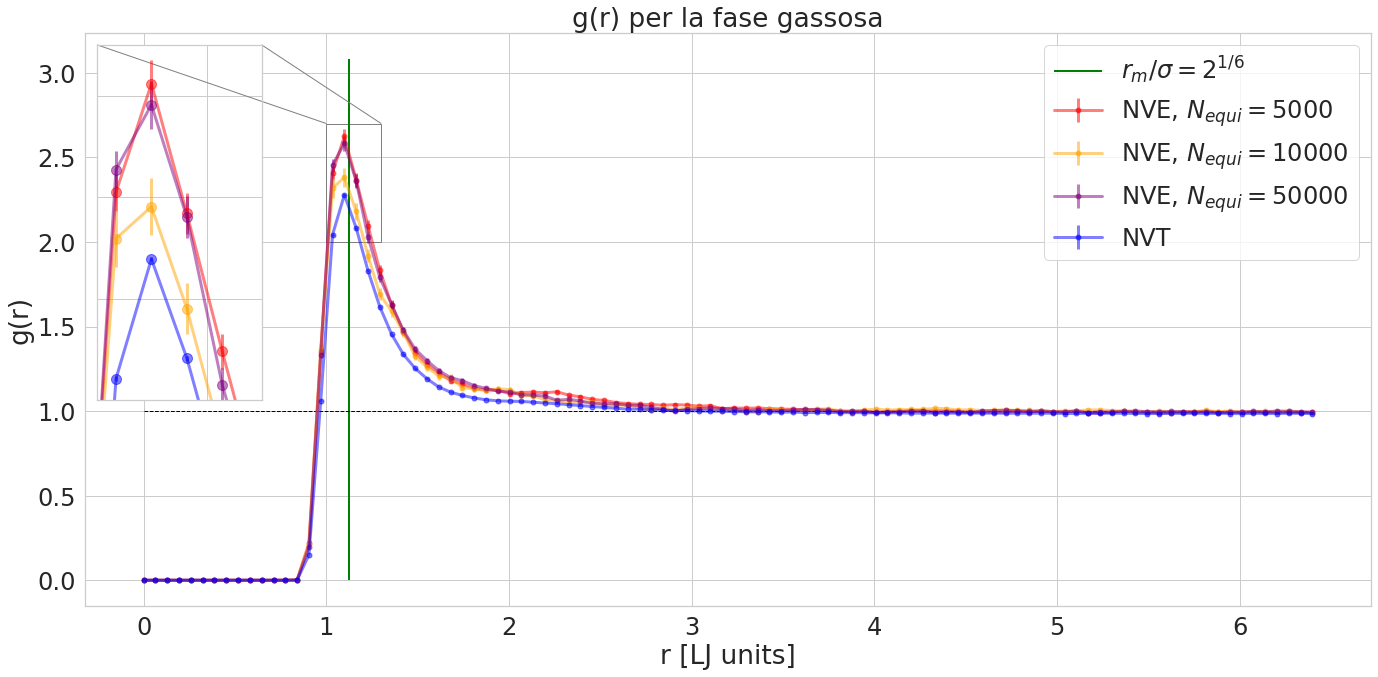

In [57]:
fig, ax = plt.subplots(figsize=[20, 10])
plt.title('g(r) per la fase gassosa')
plt.xlabel('r [LJ units]')
plt.ylabel('g(r)')
plt.tight_layout()    
    
axins=zoomed_inset_axes(ax,3,loc=2)   
x1, x2, y1, y2 = 1, 1.3, 2, 2.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
    
ax.errorbar(r_range[2], hist_vals_gas_05k, yerr=hist_errs_gas_05k, color='red', linewidth=3, alpha=0.5, label=r'NVE, $N_{equi}=5000$', marker='.', markersize=10)
axins.errorbar(r_range[2], hist_vals_gas_05k, yerr=hist_errs_gas_05k, color='red', linewidth=3, alpha=0.5, label=r'NVE $N_{equi}=5000$', marker='.', markersize=20)
ax.errorbar(r_range[2], hist_vals_gas_10k, yerr=hist_errs_gas_10k, color='orange', linewidth=3, alpha=0.5, label=r'NVE, $N_{equi}=10000$', marker='.', markersize=10)
axins.errorbar(r_range[2], hist_vals_gas_10k, yerr=hist_errs_gas_10k, color='orange', linewidth=3, alpha=0.5, label=r'NVE $N_{equi}=10000$', marker='.', markersize=20)
ax.errorbar(r_range[2], hist_vals_gas_50k, yerr=hist_errs_gas_05k, color='purple', linewidth=3, alpha=0.5, label=r'NVE, $N_{equi}=50000$', marker='.', markersize=10)
axins.errorbar(r_range[2], hist_vals_gas_50k, yerr=hist_errs_gas_05k, color='purple', linewidth=3, alpha=0.5, label=r'NVE $N_{equi}=50000$', marker='.', markersize=20)
ax.errorbar(r_range[2], gofr_NVT[2], yerr=err_NVT[2], color='blue', linewidth=3, alpha=0.5, label='NVT', marker='.', markersize=10)
axins.errorbar(r_range[2], gofr_NVT[2], yerr=err_NVT[2], color='blue', linewidth=3, alpha=0.5, label='NVT', marker='.', markersize=20)
ax.vlines(2**(1/6), 0, np.max(hist_vals_gas_50k)+0.5, color='green', linewidth=2, label=r'$r_m/\sigma = 2^{1/6}$')

ax.legend()
ax.hlines(1, 0, r_range[2][99], linestyle='--', color='black', linewidth=1)
mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')

plt.show()

__Figure 4,5,6:__ come prima cosa vorrei sottolineare che, anche utilizzando due metodi profondamente e concettualmente diversi tra loro, abbiamo ottenuto dei risultati molto simili andando a misurare la distribuzione delle coppie. Questo è interessante, perché significa che, indipendentemente dal metodo, le particelle si dispongono nello spazio del box in cui stiamo simulando in modi che mostrano lo stesso tipo di correlazione spaziale. Entrando più nel dettaglio del confronto tra le stime delle $g(r)$; per tutti e tre gli stati, entrambi i metodi, mostrano dei comportamenti analogi: innanzi tutto notiamo che la probabilità di trovare due particelle a raggi $r<1$ tende rapidamente a zero. Il potenziale che governa i due tipi di simulazioni è quello di Lennard-Jones, il quale esprime una forte repulsione tra le particelle per raggi piccoli (domina $r^{-12}$). Quando invece consideriamo raggi più grandi, notiamo che le funzioni tendono ad oscillare o assestarsi attorno al valore uno. In pratica è come se in queste regioni non si registrasse alcun tipo di "sovra-densità" nel sistema. Questo è sintomatico del fatto che, a distanze molto grandi (quando il potenziale diventa trascurabile), è come se le particelle fossero libere. Questo aspetto lo leggiamo in modo più chiaro nel caso del gas, che è disperso su un volume più grande e i cui elementi rispecchiano in modo maggiore l'ipotesi di "particella libera".

Per confrontare le due simulazioni: il caso dello stato solido è quello in cui registriamo misure più simili riguardanti i valori che la $g(r)$ assume nei cento punti considerati nell'analisi. Nel caso del liquido notiamo un comportamento simile delle due curve, fatta eccezione per i raggi corrispondenti alla regione relativa al primo massimo della distribuzione (il minimo del potenziale). Nel caso del gas notiamo delle differenze più consistenti tra le misure: in particolare, il variare dei parametri utilizzati nelle simulazioni di dinamica molecolare comporta risultati anche molto diversi (particolarmente nella regione in cui compare il massimo della funzione). La simulazione di dinamica molecolare che si è avvicinata maggiormente ai risultati ottenuti tramite NVT è quella in cui ho adoperato diecimila passi di equilibrazione. In quel caso avevo deciso di diminuire la taglia dei blocchi a $1000$ elementi seppur mantenendo uguale il numero di blocchi (100). Inoltre, in quella simulazione ho eseguito due variazioni di temperatura in fase di equilibrazione, passando da $T_1=0.8$ a $T_2=1.0$ dopo $N_{equi}/10$ passi e da $T_2$ a $T^*=1.2$ al passo $N_{equi}/5$.

---

Raccolgo infine le misure ottenute di $U/N$ e $P$, con relative incertezze, in tutte le condizioni analizzate (sono stampati solamente gli ultimi valori ottenuti tramite ciascun metodo di media a blocchi):

In [67]:
# Scriviamo le grandezze in unità SI

sigma = 0.34 * 10**-9        # m
k_b = 1.380649 * 10**-23     # J/K
eps = 120 * k_b              # J
m = 39.948 * 1.66054*10**-27 # kg

def U_to_SI(U, errU):
    for i in range(6):
        U[i]    *= eps
        errU[i] *= eps

def P_to_SI(P, errP):
    for i in range(6):
        P[i]    *= eps/sigma**3
        errP[i] *= eps/sigma**3

    
U_to_SI(NVT_meas_U, NVT_err_U)
P_to_SI(NVT_meas_P, NVT_err_P)

In [74]:
def plot_blocking(nblks ,data, errors, meas, col):
    plt.figure(figsize=(25,7))
    myx = np.arange(nblks)
    
    plt.suptitle("Stime di " + meas)
    
    plt.subplot(1,3,1)
    plt.title("solido")
    plt.errorbar(myx, data[3], yerr=errors[3], label='', alpha=0.5, color=col, lw=5)
    plt.ylabel(meas)
    plt.xlabel('# blocchi')
    
    plt.subplot(1,3,2)
    plt.title("liquido")
    plt.errorbar(myx, data[4], yerr=errors[4], label='', alpha=0.5, color=col, lw=5)
    plt.ylabel(meas)
    plt.xlabel('# blocchi')
    
    plt.subplot(1,3,3)
    plt.title("gas")
    plt.errorbar(myx, data[5], yerr=errors[5], label='', alpha=0.5, color=col, lw=5)
    plt.ylabel(meas)
    plt.xlabel('# blocchi')
    
    plt.tight_layout()
    plt.show()

### Stime di $U/N$ e $P$ ottenute tramite NVT

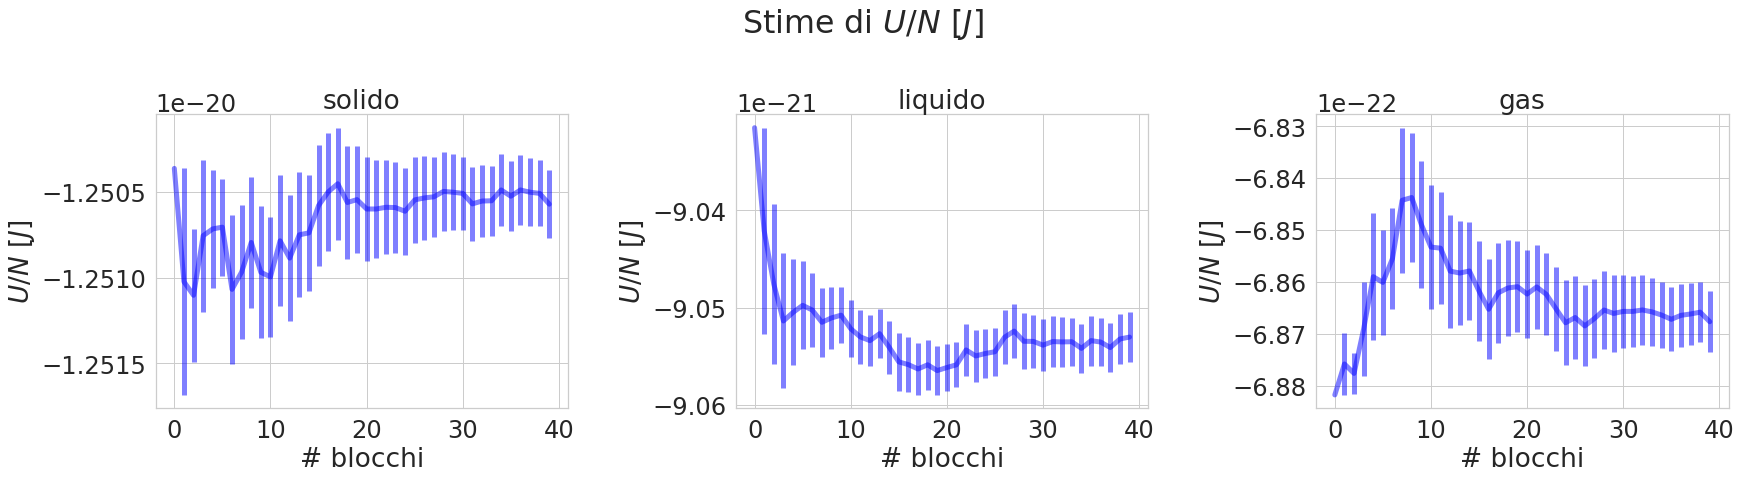

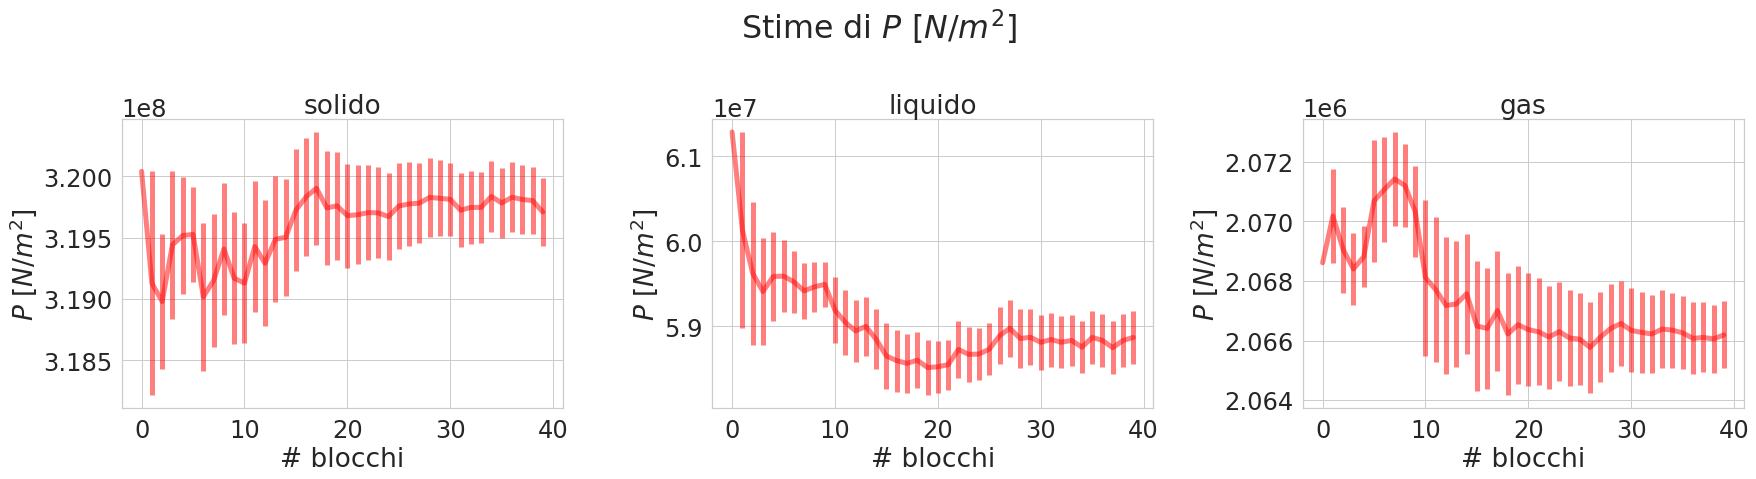

In [75]:
plot_blocking(40, NVT_meas_U, NVT_err_U, r"$U/N\,\, [J]$", 'blue')
plot_blocking(40, NVT_meas_P, NVT_err_P, r"$P\,\, [N/m^2]$", 'red')

__Figura 7:__ seppur con qualche differenza, i risultati ottenuti nella misura di $U/N$ sono simili a quelli registrati nell'esercitazione quattro. Abbiamo dunque a disposizione due metodi che ci permettono di affrontare lo stesso problema. 